# IntelliSnap : Smart Object Classification
# Team Members :
## Aniruddho Swapan Chatterjee - caswapan
## Piyush Rajendra Chaudhari - piyrchau
## Prashul Kumar - praskuma

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import warnings
warnings.filterwarnings("ignore") 

### Take at least 100 images per class with at least 3 classes using your phone/camera (you can take advantage of spring in Bloomington and take photos of different trees, flowers, animals). Display 5 examples from each class.

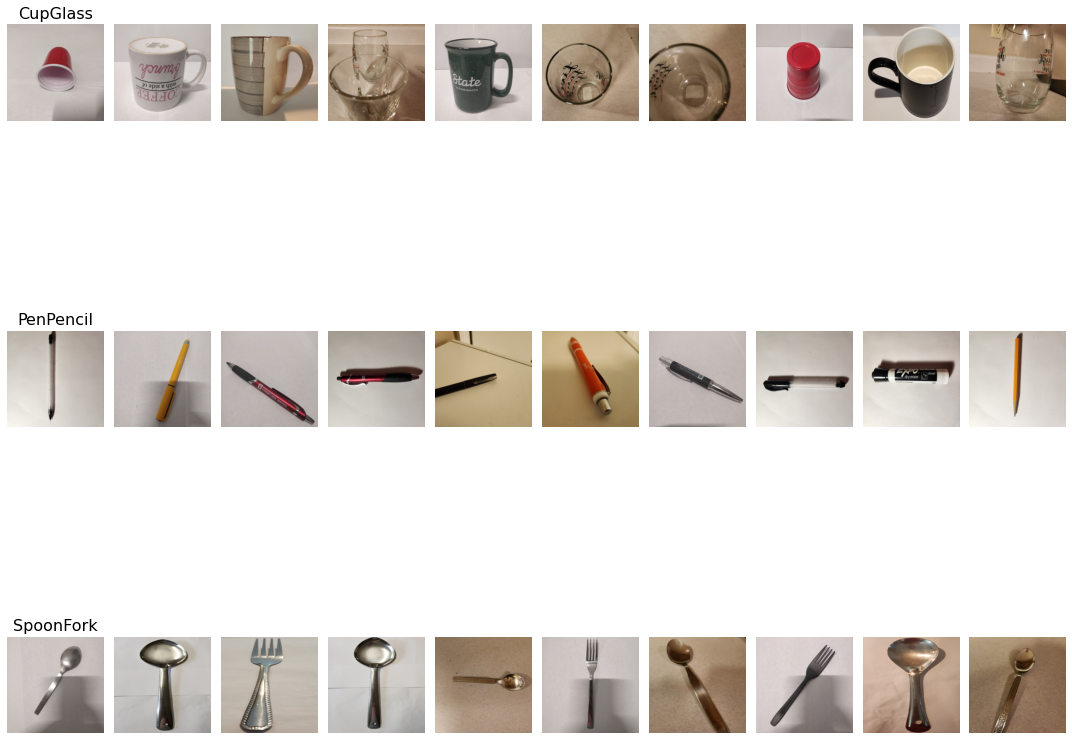

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


dataset_dir = "Dataset"

classes = ["CupsGlass", "PenPencil", "SpoonFork"]

dataset_dir = r'/N/u/caswapan/Carbonate/Applied Machine Learning/Homework 4 - Big Red/Dataset'

classes = ["CupGlass", "PenPencil", "SpoonFork"]

# Define the number of examples to display from each class
num_examples = 10

# Define the size of the images to resize to
img_size = (224, 224)

# Define the number of rows and columns to display the images in
nrows = len(classes)
ncols = num_examples

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
for row, class_name in enumerate(classes):
    # Get the directory path for the current class
    class_dir = os.path.join(dataset_dir, class_name)
    
    image_files = os.listdir(class_dir)
    
    examples = random.sample(image_files, num_examples)

    for col, example in enumerate(examples):
        image_path = os.path.join(class_dir, example)
        image = Image.open(image_path).resize(img_size)
        
        # Display the image
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    # Display the title for the current class
    axes[row, 0].set_title(class_name, fontsize=16)

plt.tight_layout()
plt.show()


#### Split the images into a training set, a validation set, and a test set.

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split
from shutil import copyfile

dataset_dir = "Dataset"
train_dir = "Train"
val_dir = "Validation"
test_dir = "Test"

classes = ["CupsGlass", "PenPencil", "SpoonFork"]

dataset_dir = r'/N/u/caswapan/Carbonate/Applied Machine Learning/Homework 4 - Big Red/Dataset'

classes = ["CupGlass", "PenPencil", "SpoonFork"]

# Define the size of the images to resize to
img_size = (224, 224)

# Define the proportion of images to allocate to each set
train_pct = 0.6  # 60% for training
val_pct = 0.2  # 20% for validation
test_pct = 0.2  # 20% for testing

# Create the directories for the training, validation, and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in classes:
    # Get the directory path for the current class
    class_dir = os.path.join(dataset_dir, class_name)

    # Get the list of image files in the current class
    image_files = os.listdir(class_dir)

    # Split the images into training, validation, and test sets
    train_files, test_files = train_test_split(image_files, test_size=test_pct, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=val_pct/(1-test_pct), random_state=42)

    # Copy the training images to the training directory
    train_class_dir = os.path.join(train_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    for file_name in train_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(train_class_dir, file_name)
        copyfile(src_path, dst_path)

    # Copy the validation images to the validation directory
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)
    for file_name in val_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(val_class_dir, file_name)
        copyfile(src_path, dst_path)

    # Copy the test images to the test directory
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)
    for file_name in test_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(test_class_dir, file_name)
        copyfile(src_path, dst_path)


#### Build the input pipeline, including the appropriate preprocessing operations, and add data augmentation.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (224, 224)


# Define the directories where you want to store your split datasets
train_dir = "Train"
val_dir = "Validation"
test_dir = "Test"

train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    rotation_range=20, # Rotate the images randomly
    width_shift_range=0.2, # Shift the images horizontally
    height_shift_range=0.2, # Shift the images vertically
    shear_range=0.2, # Shear the images
    zoom_range=0.2, # Zoom the images
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size, 
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False, 
    seed=42 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size, 
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False, 
    seed=42 
)

Found 228 images belonging to 3 classes.
Found 78 images belonging to 3 classes.
Found 78 images belonging to 3 classes.


In [ ]:
os.listdir()

['q1.ipynb', 'Dataset', 'q1 - Ani Data.ipynb', 'Train', 'Validation', 'Test']

#### d. Fine-tune a pretrained model of your choice on this dataset (the one you created in part c). Report classification accuracy and give a few examples of correct/incorrect classification (show a few images that were correctly/incorrectly classified).

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,))
num_classes = 3
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.1),
    metrics=['accuracy'],
    run_eagerly=True
)


history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=None,
    validation_data=val_generator,
    validation_steps=None
)


test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

predictions = model.predict(test_generator)


Epoch 1/10
8/8 [==============================] - 25s 3s/step - loss: 502.7955 - accuracy: 0.4825 - val_loss: 41.4244 - val_accuracy: 0.6410
Epoch 2/10
8/8 [==============================] - 24s 3s/step - loss: 14.4318 - accuracy: 0.5789 - val_loss: 1.2303 - val_accuracy: 0.8205
Epoch 3/10
8/8 [==============================] - 24s 3s/step - loss: 0.7478 - accuracy: 0.7632 - val_loss: 0.6524 - val_accuracy: 0.8077
Epoch 4/10
8/8 [==============================] - 23s 3s/step - loss: 0.6014 - accuracy: 0.6886 - val_loss: 0.5653 - val_accuracy: 0.6795
Epoch 5/10
8/8 [==============================] - 23s 3s/step - loss: 0.5157 - accuracy: 0.6754 - val_loss: 0.4659 - val_accuracy: 0.8846
Epoch 6/10
8/8 [==============================] - 24s 3s/step - loss: 2.6495 - accuracy: 0.7237 - val_loss: 0.3300 - val_accuracy: 0.9231
Epoch 7/10
8/8 [==============================] - 22s 3s/step - loss: 0.7214 - accuracy: 0.8465 - val_loss: 0.2354 - val_accuracy: 0.9744
Epoch 8/10
8/8 [==============

In [ ]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

predictions = model.predict(test_generator)

3/3 [==============================] - 4s 1s/step - loss: 0.3360 - accuracy: 0.9103
Test accuracy: 0.9102563858032227
3/3 [==============================] - 4s 1s/step


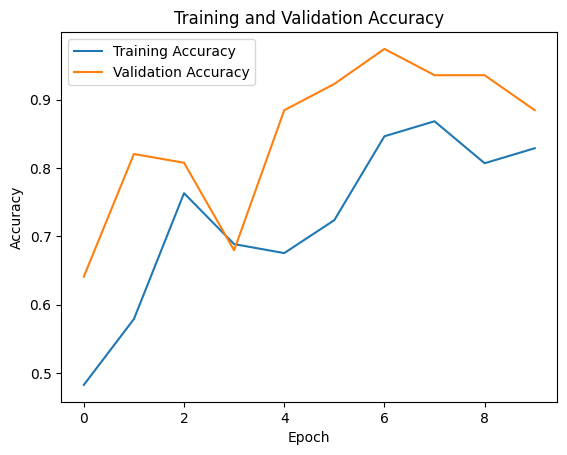

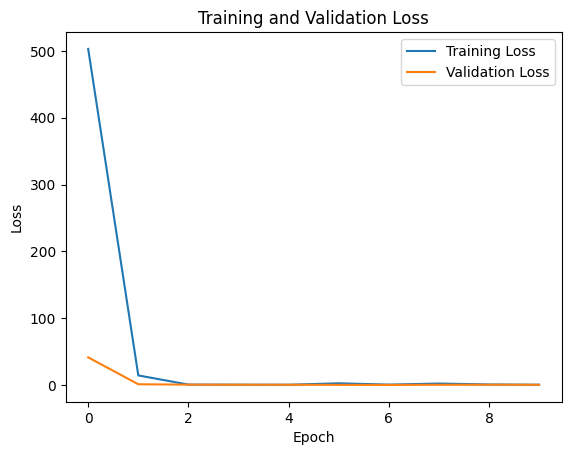

In [ ]:
import matplotlib.pyplot as plt

# Get the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curve
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curve
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate predictions
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Generate classification report
print(classification_report(y_true, y_pred, target_names=class_names))


3/3 [==============================] - 4s 1s/step
              precision    recall  f1-score   support

   CupsGlass       1.00      0.93      0.96        27
   PenPencil       0.79      1.00      0.88        26
   SpoonFork       1.00      0.80      0.89        25

    accuracy                           0.91        78
   macro avg       0.93      0.91      0.91        78
weighted avg       0.93      0.91      0.91        78



3/3 [==============================] - 4s 1s/step
Examples of correctly classified images:


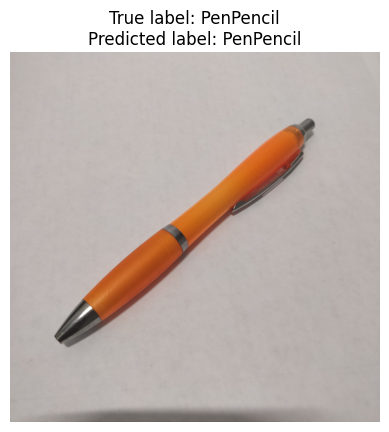

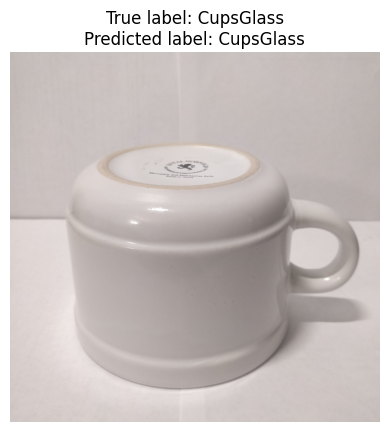

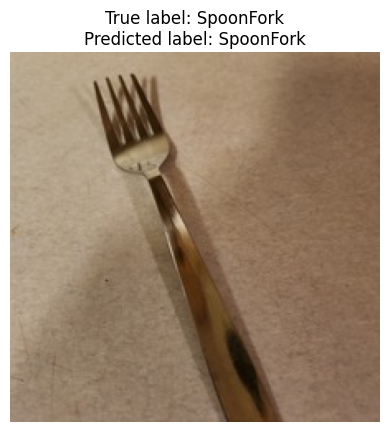

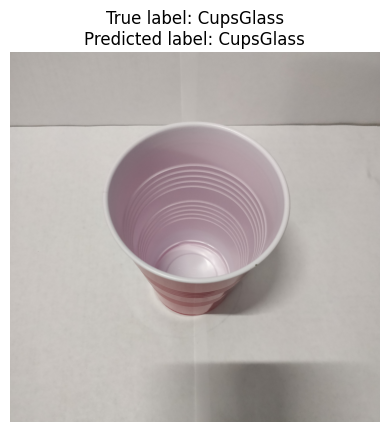

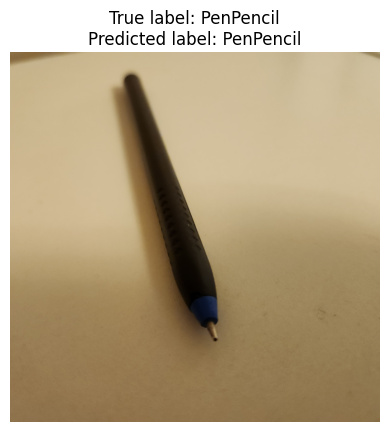

Examples of incorrectly classified images:


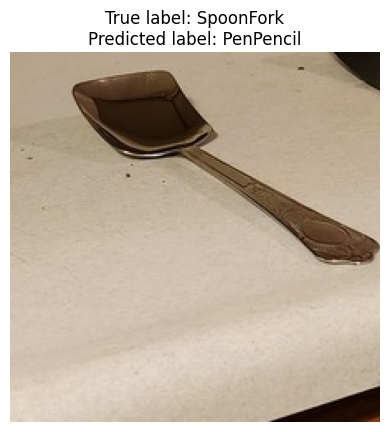

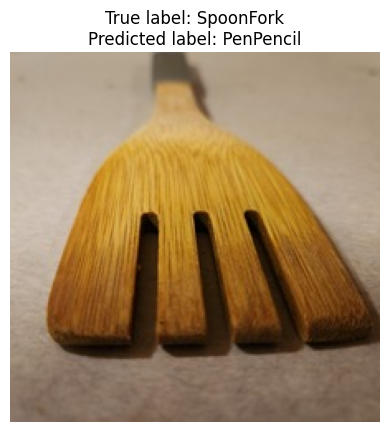

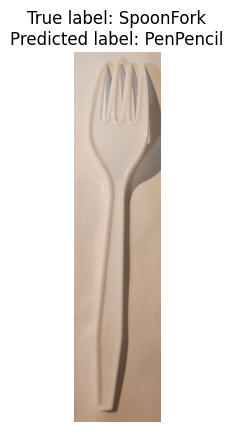

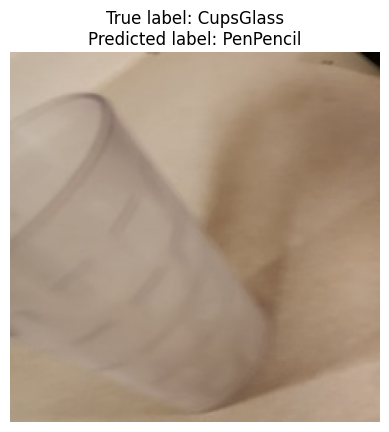

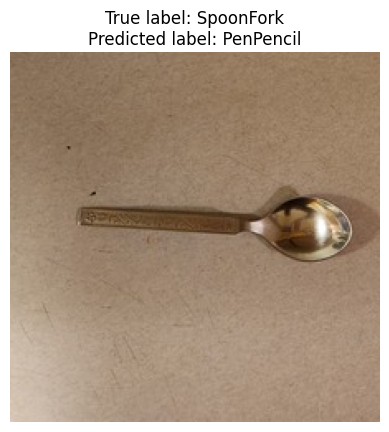

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(test_generator)
class_labels = list(train_generator.class_indices.keys())

correct_indices = np.where(np.argmax(predictions, axis=-1) == test_generator.classes)[0]
correct_images = np.random.choice(correct_indices, size=5, replace=False)

print("Examples of correctly classified images:")
for idx in correct_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()

# Plot some incorrectly classified images
incorrect_indices = np.where(np.argmax(predictions, axis=-1) != test_generator.classes)[0]
incorrect_images = np.random.choice(incorrect_indices,size=5, replace=False)

print("Examples of incorrectly classified images:")
for idx in incorrect_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()


#### Fine tuning by changing the parameters

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,))

num_classes = 3


for layer in base_model.layers[:-3]:
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x) 
x = Dropout(0.2)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(.0001),
    metrics=['accuracy']
)

class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print('Stop training ')
            self.model.stop_training = True

stop_training_callback = StopTrainingCallback()

# Use early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=None,
    validation_data=val_generator,
    validation_steps=None,
    callbacks=[early_stop, stop_training_callback]
)

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

predictions = model.predict(test_generator)


Epoch 1/50
8/8 [==============================] - 22s 2s/step - loss: 10.9871 - accuracy: 0.3333 - val_loss: 10.0823 - val_accuracy: 0.6282
Epoch 2/50
8/8 [==============================] - 19s 2s/step - loss: 9.6395 - accuracy: 0.5439 - val_loss: 8.8057 - val_accuracy: 0.6795
Epoch 3/50
8/8 [==============================] - 19s 2s/step - loss: 8.3307 - accuracy: 0.7018 - val_loss: 7.5090 - val_accuracy: 0.9231
Epoch 4/50
8/8 [==============================] - 18s 2s/step - loss: 7.4259 - accuracy: 0.7939 - val_loss: 6.9285 - val_accuracy: 0.8333
Epoch 5/50
8/8 [==============================] - 19s 2s/step - loss: 6.6764 - accuracy: 0.8289 - val_loss: 6.1243 - val_accuracy: 0.8846
Epoch 6/50
8/8 [==============================] - 20s 2s/step - loss: 5.9837 - accuracy: 0.8377 - val_loss: 5.6238 - val_accuracy: 0.9487
Epoch 7/50
8/8 [==============================] - 20s 3s/step - loss: 5.5026 - accuracy: 0.8816 - val_loss: 5.1022 - val_accuracy: 0.9359
Epoch 8/50
8/8 [================

In [ ]:
model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

predictions = model.predict(test_generator)

3/3 [==============================] - 4s 984ms/step - loss: 2.1252 - accuracy: 0.9744
Test accuracy: 0.9743589758872986
3/3 [==============================] - 4s 1s/step


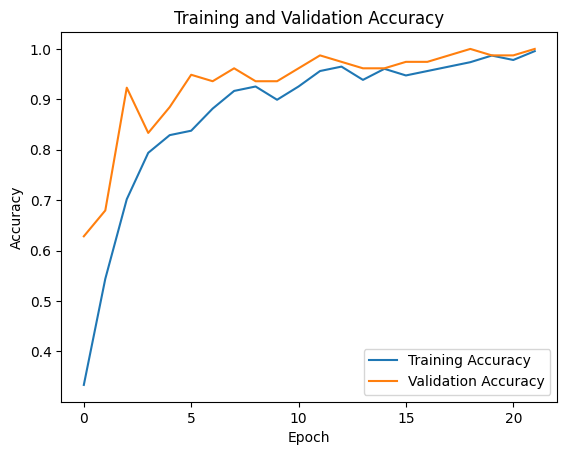

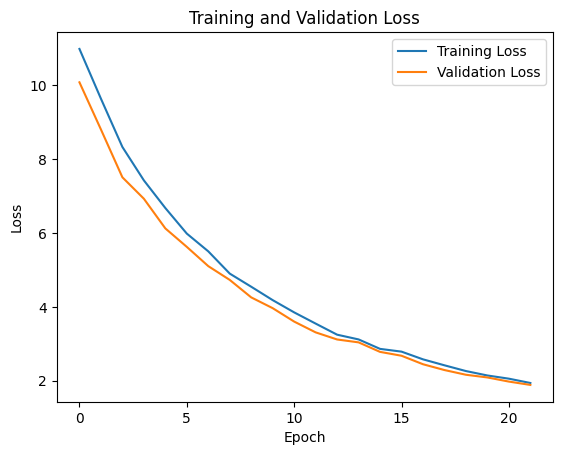

In [ ]:
import matplotlib.pyplot as plt

# Get the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curve
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curve
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate predictions
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Generate classification report
print(classification_report(y_true, y_pred, target_names=class_names))


3/3 [==============================] - 4s 1s/step
              precision    recall  f1-score   support

   CupsGlass       0.93      1.00      0.96        27
   PenPencil       1.00      0.96      0.98        26
   SpoonFork       1.00      0.96      0.98        25

    accuracy                           0.97        78
   macro avg       0.98      0.97      0.97        78
weighted avg       0.98      0.97      0.97        78



3/3 [==============================] - 4s 1s/step
Examples of correctly classified images:


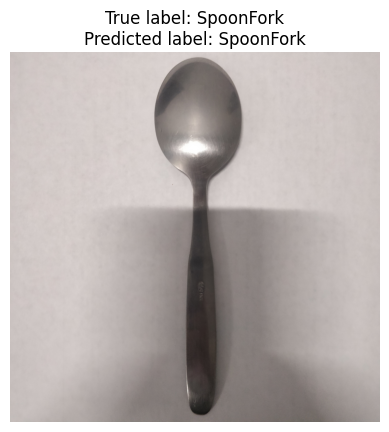

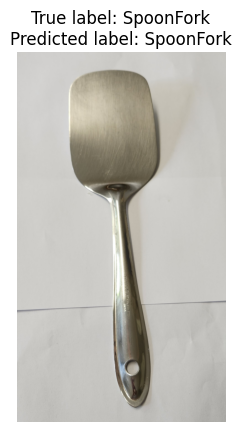

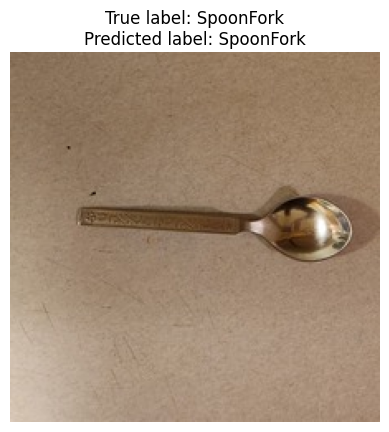

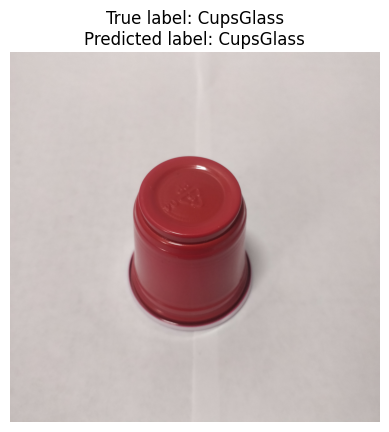

Examples of incorrectly classified images:


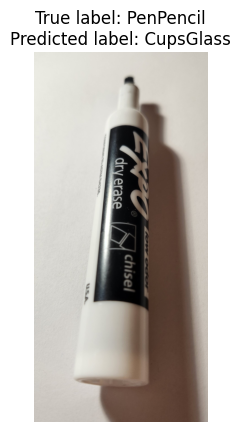

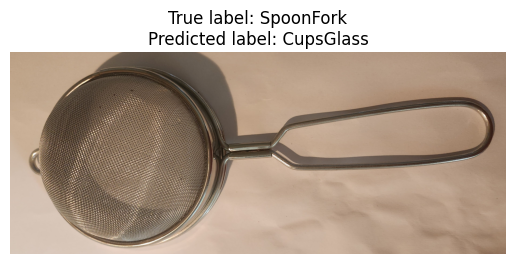

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(test_generator)
class_labels = list(train_generator.class_indices.keys())

correct_indices = np.where(np.argmax(predictions, axis=-1) == test_generator.classes)[0]
correct_images = np.random.choice(correct_indices, size=4, replace=False)

print("Examples of correctly classified images:")
for idx in correct_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()

# Plot some incorrectly classified images
incorrect_indices = np.where(np.argmax(predictions, axis=-1) != test_generator.classes)[0]
incorrect_images = np.random.choice(incorrect_indices,size=2, replace=False)

print("Examples of incorrectly classified images:")
for idx in incorrect_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()


#### After achieving a test accuracy of around 91% using default parameters, we applied some fine-tuning such as l2 regularization, dropout layer, unfreezing 3 layers and could see that the testing accuracy now increased to 97%

#### Train from scratch (without pretraining) a deep neural network that contains convolutional layers on this dataset (the one you created in part c). Report classification accuracy and give a few examples of correct/incorrect classification (show a few images that were correctly/incorrectly classified). Note: The objective of this question is to illustrate that training deep networks from scratch requires a lot of data so it is ok if your classification accuracy is low.

### Simple CNN Model

In [ ]:
# build your model and train it using the data generators
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])

class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print('Stop training ')
            self.model.stop_training = True

stop_training_callback = StopTrainingCallback()

# Use early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=None,
    validation_data=val_generator,
    validation_steps=None
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

predictions = model.predict(test_generator)


Epoch 1/50
8/8 [==============================] - 22s 3s/step - loss: 17.7640 - accuracy: 0.4298 - val_loss: 1.0860 - val_accuracy: 0.3590
Epoch 2/50
8/8 [==============================] - 21s 3s/step - loss: 17.8872 - accuracy: 0.5132 - val_loss: 3.2574 - val_accuracy: 0.3333
Epoch 3/50
8/8 [==============================] - 21s 3s/step - loss: 16.6932 - accuracy: 0.5482 - val_loss: 2.6292 - val_accuracy: 0.2564
Epoch 4/50
8/8 [==============================] - 22s 3s/step - loss: 17.9423 - accuracy: 0.5044 - val_loss: 4.2356 - val_accuracy: 0.4615
Epoch 5/50
8/8 [==============================] - 21s 3s/step - loss: 13.1063 - accuracy: 0.6228 - val_loss: 2.1696 - val_accuracy: 0.4231
Epoch 6/50
8/8 [==============================] - 19s 3s/step - loss: 9.7471 - accuracy: 0.6316 - val_loss: 4.2268 - val_accuracy: 0.5128
Epoch 7/50
8/8 [==============================] - 20s 3s/step - loss: 16.0603 - accuracy: 0.5921 - val_loss: 6.1399 - val_accuracy: 0.4615
Epoch 8/50
8/8 [============

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                      

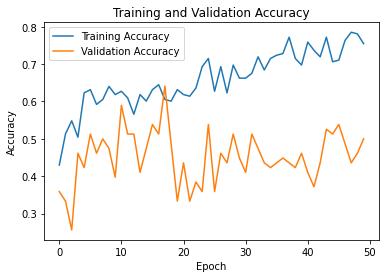

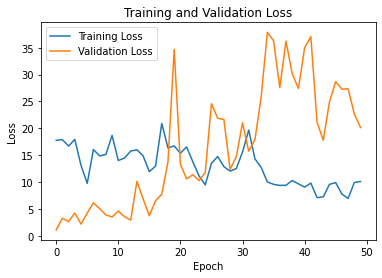

In [ ]:
import matplotlib.pyplot as plt

# Get the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curve
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curve
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate predictions
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Generate classification report
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    CupGlass       0.68      0.56      0.61        27
   PenPencil       0.50      1.00      0.67        26
   SpoonFork       1.00      0.16      0.28        25

    accuracy                           0.58        78
   macro avg       0.73      0.57      0.52        78
weighted avg       0.72      0.58      0.52        78



Examples of correctly classified images:


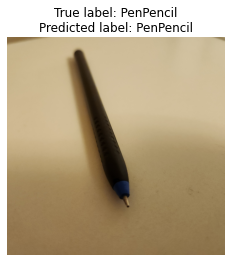

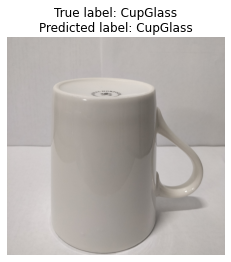

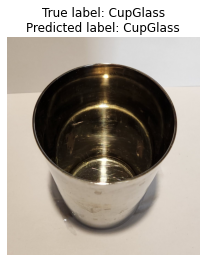

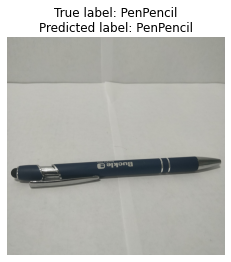

Examples of incorrectly classified images:


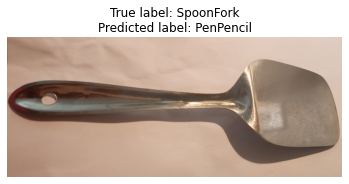

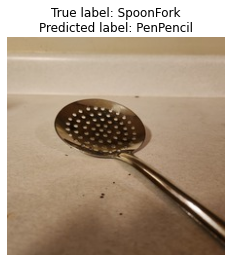

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(test_generator)
class_labels = list(train_generator.class_indices.keys())

correct_indices = np.where(np.argmax(predictions, axis=-1) == test_generator.classes)[0]
correct_images = np.random.choice(correct_indices, size=4, replace=False)

print("Examples of correctly classified images:")
for idx in correct_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()

# Plot some incorrectly classified images
incorrect_indices = np.where(np.argmax(predictions, axis=-1) != test_generator.classes)[0]
incorrect_images = np.random.choice(incorrect_indices,size=2, replace=False)

print("Examples of incorrectly classified images:")
for idx in incorrect_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()


#### Complex CNN Model with Hyper Parameter Tuning
##### Adam Optimizer with Learning Rate 0.0001, Dropout and L2 regularizer has been used to prevent model from overfit

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Define the optimizer and learning rate
opt = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

predictions = model.predict(test_generator)



Epoch 1/50
9/9 [==============================] - 124s 13s/step - loss: 3.5564 - accuracy: 0.4586 - val_loss: 2.9215 - val_accuracy: 0.2500
Epoch 2/50
9/9 [==============================] - 128s 14s/step - loss: 2.9777 - accuracy: 0.5977 - val_loss: 3.7714 - val_accuracy: 0.3000
Epoch 3/50
9/9 [==============================] - 119s 13s/step - loss: 2.9914 - accuracy: 0.6241 - val_loss: 3.4388 - val_accuracy: 0.3500
Epoch 4/50
9/9 [==============================] - 124s 13s/step - loss: 2.9686 - accuracy: 0.6429 - val_loss: 3.2231 - val_accuracy: 0.4000
Epoch 5/50
9/9 [==============================] - 120s 13s/step - loss: 2.9300 - accuracy: 0.7293 - val_loss: 3.2013 - val_accuracy: 0.4750
Epoch 6/50
9/9 [==============================] - 148s 17s/step - loss: 2.8771 - accuracy: 0.7293 - val_loss: 3.1076 - val_accuracy: 0.6000
Epoch 7/50
9/9 [==============================] - 144s 14s/step - loss: 2.7470 - accuracy: 0.7556 - val_loss: 3.0350 - val_accuracy: 0.4500
Epoch 8/50
9/9 [====

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_13 (Bat  (None, 222, 222, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 batch_normalization_14 (Bat  (None, 109, 109, 128)    512       
 chNormalization)                                                
                                                      

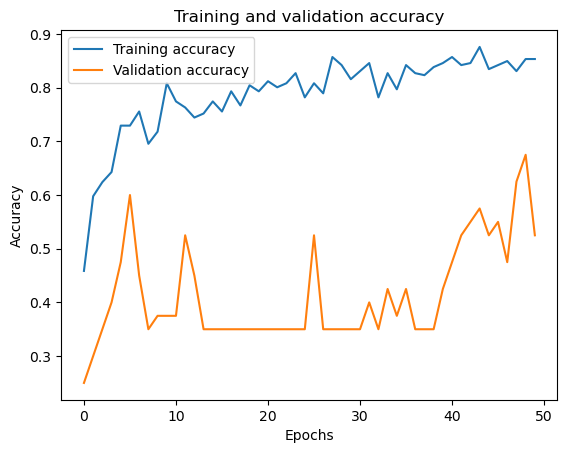

In [ ]:
## plotting the training and validation accuracy :

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

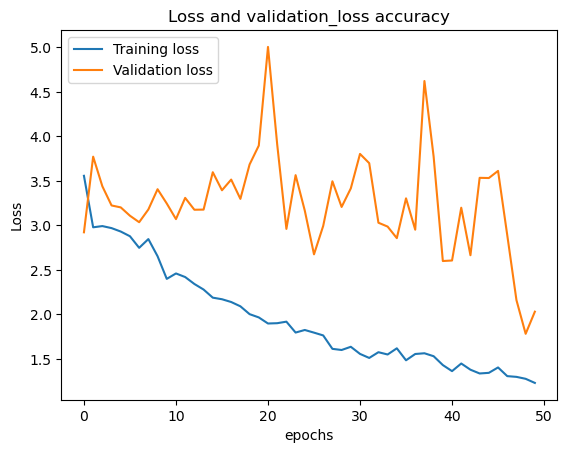

In [ ]:
## Let's plot the loss and validation_loss curves :

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss and validation_loss accuracy')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions

array([[2.66096085e-01, 7.33160257e-01, 7.43615383e-04],
       [9.98235345e-01, 1.11998047e-03, 6.44659158e-04],
       [8.68190452e-02, 9.11628962e-01, 1.55202160e-03],
       [9.51016247e-01, 3.80254686e-02, 1.09583810e-02],
       [9.92229283e-01, 2.55984836e-03, 5.21081500e-03],
       [9.21015382e-01, 7.17739612e-02, 7.21065188e-03],
       [9.23258662e-01, 6.30042842e-03, 7.04409331e-02],
       [9.26763058e-01, 6.39542378e-03, 6.68415204e-02],
       [9.06568289e-01, 4.95665744e-02, 4.38650511e-02],
       [9.75333810e-01, 1.79681883e-04, 2.44865548e-02],
       [9.55187678e-01, 1.45424696e-04, 4.46669683e-02],
       [5.66521823e-01, 9.33876634e-03, 4.24139410e-01],
       [9.10381079e-01, 7.02763384e-04, 8.89161527e-02],
       [6.71769917e-01, 1.10660056e-02, 3.17164063e-01],
       [8.21232557e-01, 1.10874476e-03, 1.77658796e-01],
       [8.26001287e-01, 9.84279788e-04, 1.73014462e-01],
       [9.96585250e-01, 9.93020367e-04, 2.42165127e-03],
       [2.82221437e-01, 7.11215

3/3 [==============================] - 50s 15s/step
Examples of correctly classified images:


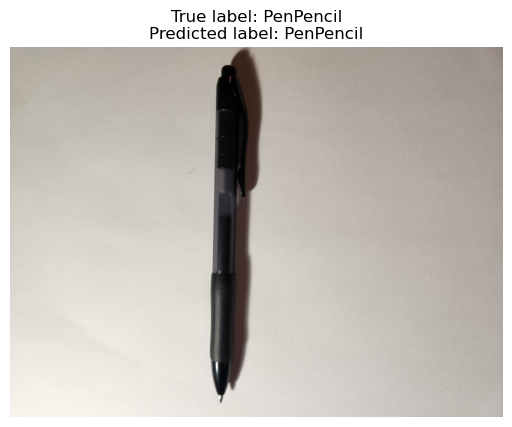

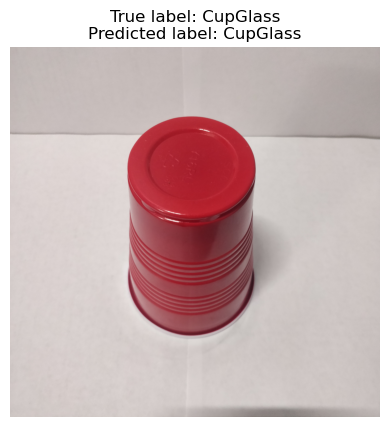

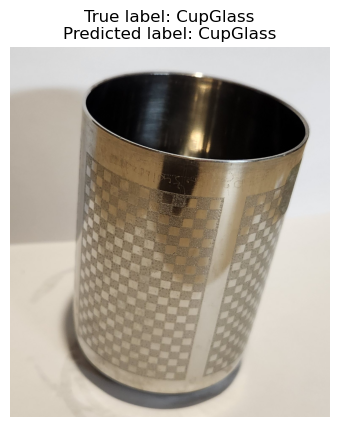

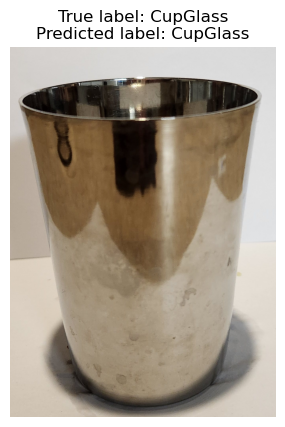

Examples of incorrectly classified images:


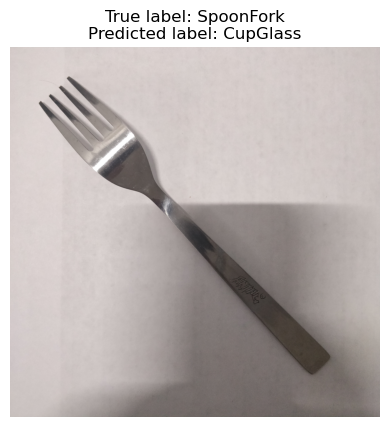

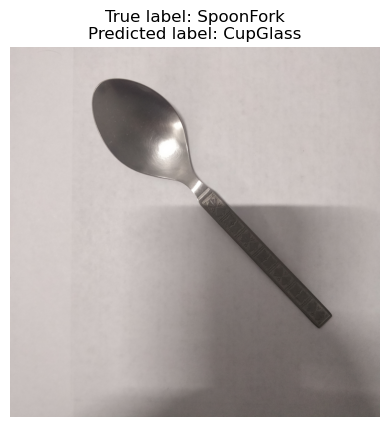

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(test_generator)
class_labels = list(train_generator.class_indices.keys())

correct_indices = np.where(np.argmax(predictions, axis=-1) == test_generator.classes)[0]
correct_images = np.random.choice(correct_indices, size=4, replace=False)

print("Examples of correctly classified images:")
for idx in correct_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()

# Plot some incorrectly classified images
incorrect_indices = np.where(np.argmax(predictions, axis=-1) != test_generator.classes)[0]
incorrect_images = np.random.choice(incorrect_indices,size=2, replace=False)

print("Examples of incorrectly classified images:")
for idx in incorrect_images:
    image_path = test_generator.filepaths[idx]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"True label: {class_labels[test_generator.classes[idx]]}\nPredicted label: {class_labels[np.argmax(predictions[idx])]}")
    plt.axis("off")
    plt.show()


#### Conclusion

The Convolution Neural Network build from scratch gives an accuracy of 57.69%
on the Testing set with a simple CNN layers without hyper parameter tuning.

On tuning the hyper parameters such as Adam Optimizer with Learning rate as 0.0001, Dropout rate and adding a L2 regularizer to prevent overfit of the model, the final model gives an accuracy of 62.82% on the Testing dataset.

Thus after tuning the hyper parameters, better results are obtained.

The accuracy and loss v/s Epochs of the Training and the Validation shows fluctuations per epochs in both the Simple CNN model as well asthe one with hyper parameter tuning.

Lastly, the examples of images correctly classified and wrongly classified are shown for both the models.